# Genetic Algorithm to solve the D-EVRP-NL
This notebook allows you to work with the implemented library and solve the Dynamic Electric Vehicle Routing Problem with Non-linear charging functions. The main purpose is to give good visualization of the solution and easy handling of network complexity.

## Initialization

First, import required libraries.

In [1]:
# Too work with arguments and script paths
import sys

# scientific libraries and tutilities
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

# setup pyplot
conf = {'font.size': 20}
plt.rcParams.update(conf)

# GA library
from deap import base
from deap import creator
from deap import tools

# Visualization tools
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.layouts import row as layout_row
from bokeh.models.annotations import Arrow, Label
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models import ColumnDataSource, Div, Whisker, Span, Range1d
from bokeh.io import export_svgs, export_png

# Simulation environment tools
sys.path.append('..')
import res.EV_utilities
import res.GA_utilities_1

# Display useful loading of bokeh library and start timer
output_notebook()
t0 = time.time()

Loading BokehJS ...

The following are user-defined variables

In [2]:
# Network size and where are data files stored
networkSize = 30
folderPath = '../data/GA_implementation/'

# Charging stations points
chargingTimePoints = True
timePoints = [0.0, 40.0, 60., 120.]
socPoints = [0.0, 75.0, 90.0, 100.0]

# figure related
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 500

figureFolderPath = "../data/GA_implementation/"+str(networkSize)+"network_variation/"

The following implements some utility functions, not related to main GA

In [3]:
# %% Utilities
def shapeItems(items, shape=(None, 2)):
    numOfItems = len(items)
    columns = shape[1]

    if shape[0] is None:
        rows = int(numOfItems / columns) + int(numOfItems % columns)
    else:
        rows = shape[0]

    gridList = [[None] * columns for _ in range(0, rows)]

    i = 0
    j = 0
    for fig in items:
        if j == columns:
            i += 1
            j = 0
        gridList[i][j] = fig
        j += 1
    return gridList

## Import data
There are three main data files:
    - Time matrix: containing the time it takes to travel along arcs between each node
    - Energy matrix: cantaining the energy it takes to travel along arcs between each node
    - Info file: containing the information of each node

In [4]:
# %% Import time and energy matrices and show a value example

pathTM = folderPath + 'timeMatrix_' + str(networkSize) + 'nodes.csv'
timeMatrix = pd.read_csv(pathTM).set_index("TT(MIN)")

print('Time matrix:\n', timeMatrix, "\n")

pathEM = folderPath + 'energyMatrix_' + str(networkSize) + 'nodes.csv'
energyMatrix = pd.read_csv(pathEM).set_index("ENERGY(AH)")

print('Energy matrix:\n', energyMatrix, '\n')

# Indexing example
print("An index example...")
t = timeMatrix.iat[1, 2]
print("Travel time from 1 to 2: ", t)

e = energyMatrix.iat[1, 2]
print("Energy consumption from 1 to 2: ", e, '\n')


Time matrix:
                  0          1          2          3          4          5  \
TT(MIN)                                                                     
0         0.000000  19.461347  18.978988  13.148921   9.717353  12.218160   
1        16.493709   0.000000  12.248480  18.882980   8.871050  19.760969   
2         8.749181   9.510101   0.000000   9.718716   8.723837  10.651628   
3        15.071604  19.956029   8.004054   0.000000   8.328253  15.761568   
4        18.321813  14.079354  11.400399  13.441945   0.000000  10.188385   
5        13.129251  14.277677  12.934420  17.542826  10.400436   0.000000   
6        16.718770  15.227973  17.584267  17.581704  11.740838  14.485349   
7         9.773022  18.981200  19.692553  16.201921  18.986956  13.244679   
8        15.595551  10.394889  11.511726  19.491460  13.725072  18.932637   
9        12.956503  15.065482   8.913761   8.955467  10.597430  19.375507   
10       15.091891  10.984494  16.901587  13.808664  15.051596

In [5]:
# %% Import nodes information to differentiate among them

infoMatrix = pd.read_csv(folderPath + 'infoMatrix_' + str(networkSize) + 'nodes.csv')

depotDF = infoMatrix[infoMatrix['TYPE'] == 'DEPOT'].dropna(axis=1)
customerDF = infoMatrix[infoMatrix['TYPE'] == 'CUSTOMER'].dropna(axis=1)
csDF = infoMatrix[infoMatrix['TYPE'] == 'CS'].dropna(axis=1)

print('Depots DF:\n', depotDF, '\n')
print('Customers DF:\n', customerDF, '\n')
print('Charge Stations DF\n', csDF, '\n')


Depots DF:
    ID  POS_X  POS_Y   TYPE
0   0    0.0    0.0  DEPOT 

Customers DF:
     ID    DEMAND       POS_X       POS_Y  SERVICE_TIME  TIME_WINDOW_LOW  \
1    1  0.193070    2.900621 -115.774200      9.126911       642.166928   
2    2  0.197672  -90.875017 -103.370371      2.651879       630.665622   
3    3  0.438245   46.516821   20.163101      5.557819       735.303201   
4    4  0.374963   -4.359159   41.650064      7.049608       818.580036   
5    5  0.131632  -87.095251  128.085678      8.125989       913.992573   
6    6  0.272627  -52.455049   70.151008      5.738071       844.952962   
7    7  0.320439   78.247857   55.963501      7.154479       928.146763   
8    8  0.105744   70.829963  102.637077      7.249441       835.056700   
9    9  0.255904   75.751425  142.944511      1.862994       722.042194   
10  10  0.433611  107.073285  -78.703290      1.196350       731.541761   
11  11  0.169499   19.786420  100.184969      5.157274       658.263866   
12  12  0.258370 

## Create variables

In [6]:
# Create list with information

networkDict = {'DEPOT_LIST': [], 'CUSTOMER_LIST': [], 'CS_LIST': [],
               'TIME_MATRIX': timeMatrix, 'ENERGY_MATRIX': energyMatrix}

for _, row in depotDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.DepotNode(row['ID'])
    networkDict['DEPOT_LIST'].append(networkDict[row['ID']])

for _, row in customerDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.CustomerNode(row['ID'], row['SERVICE_TIME'], row['DEMAND'],
                                                           timeWindowUp=row['TIME_WINDOW_UP'],
                                                           timeWindowDown=row['TIME_WINDOW_LOW'])
    networkDict['CUSTOMER_LIST'].append(networkDict[row['ID']])

figureList = []

for _, row in csDF.iterrows():
    # Simple CS with linear curve
    if chargingTimePoints:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'],
                                                                    timePoints=timePoints,
                                                                    socPoints=socPoints)
    else:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'])

    networkDict['CS_LIST'].append(networkDict[row['ID']])
    # Append to show as grid
    s = figure(width=400, height=250, title='Charging function of CS ' + str(networkDict[row['ID']].id))

    s.xaxis.axis_label = 'Time (min)'
    s.yaxis.axis_label = 'SOC (%)'
    s.line(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', line_width=2)
    s.asterisk(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', size=10)
    
    # Save
    s.output_backend = "svg"
    export_svgs(s, filename=figureFolderPath+"CS"+str(row['ID'])+"_chargingFunction.svg")
    
    figureList.append(s)

# show grid
shapedFigs = shapeItems(figureList, shape=(None, 2))
p = gridplot(shapedFigs, toolbar_location='left')
show(p)


## Assign customers to each EV

In [7]:
# %% Number of cars and their random set to visit. Ensure that each one of them visit at least one

t1 = time.time()

nVehicles = 4
chooseCustomersRandom = False

vehiclesDict = {}

if chooseCustomersRandom:
    # Choose the customers each vehicle will visit randomly
    customersID = [evID for evID in customerDF['ID']]
    nCustomers = len(customersID)
    nCustomersPerCar = [int(nCustomers / nVehicles)] * nVehicles

    if len(customersID) % nVehicles != 0:
        nCustomersPerCar[-1] = int(len(customersID) / nVehicles) + 1

    for i, j in enumerate(nCustomersPerCar):
        print('Car', i, 'must visit', j, 'customer/s')
    print('\n')

    for carId, nCustomersCar in enumerate(nCustomersPerCar):
        carCustomersId = []
        for j in range(0, nCustomersCar):
            index = random.randint(0, len(customersID) - 1)
            carCustomersId.append(customersID.pop(index))
        customersToVisit = [customerId for customerId in carCustomersId]
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        x1 = 24.0 * 30.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x1=x1, x2=Qi, x3=sumDi)
else:
    customersID = [[14,1,2,13,26,11,10,18],
                   [4,25,6,27,9,8,29],
                   [22,16,19,12,17,28],
                   [3,20,21,5,7,23]]
    for i, l in enumerate(customersID):
        print('Car',i,'must visit', len(l),'customers')
        
    nCustomers = sum([len(x) for x in customersID])

    for carId, customersToVisit in enumerate(customersID):
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        # IMPORTANT: the proposed nodeSequence
        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x2=Qi, x3=sumDi)


Car 0 must visit 8 customers
Car 1 must visit 7 customers
Car 2 must visit 6 customers
Car 3 must visit 6 customers
Car 0 must visit customers with ID: [14, 1, 2, 13, 26, 11, 10, 18]
Car 1 must visit customers with ID: [4, 25, 6, 27, 9, 8, 29]
Car 2 must visit customers with ID: [22, 16, 19, 12, 17, 28]
Car 3 must visit customers with ID: [3, 20, 21, 5, 7, 23]


 ## Setup GA

In [8]:
# %% Genetic algorithm

# allowed charging operations
numChargeOp = 2

# Build toolbox and useful classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Individual initializer
toolbox.register("individual", res.GA_utilities_1.createRandomIndividual, vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Fitness, crossover, mutation and selection
toolbox.register("evaluate", res.GA_utilities_1.fitness, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mate", res.GA_utilities_1.crossover, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mutate", res.GA_utilities_1.mutate, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("select", tools.selTournament, tournsize=3)

# Useful to decode
toolbox.register("decode", res.GA_utilities_1.decodeFunction, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Constraint handling
toolbox.register("distance", res.GA_utilities_1.distanceToFeasibleZone, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("feasible", res.GA_utilities_1.feasibleIndividual, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, -500000.0, toolbox.distance))

## Run GA

In [9]:
# %% the algorithm

tInitGA = time.time()
# Population TODO create function
n = 100
generations = 240

pop = []
for i in range(0, n):
    pop.append(creator.Individual(toolbox.individual()))

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.4, 0.4

print("################  Start of evolution  ################")

# Evaluate the entire population
# fitnesses = list(map(toolbox.evaluate, pop))

for ind in pop:
    fit = toolbox.evaluate(ind)
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
Ymax = []
Ymin = []
Yavg = []
Ystd = []
X = []

bestOfAll = tools.selBest(pop, 1)[0]

# Begin the evolution
while g < generations:
    # A new generation
    g = g + 1
    X.append(g)
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    Ymax.append(-max(fits))
    Ymin.append(-min(fits))
    Yavg.append(mean)
    Ystd.append(std)

    bestInd = tools.selBest(pop, 1)[0]
    print("Best individual: ", bestInd)

    worstInd = tools.selWorst(pop, 1)[0]
    print("Worst individual: ", worstInd)

    # Save best ind
    if bestInd.fitness.values[0] > bestOfAll.fitness.values[0]:
        bestOfAll = bestInd

# %%
print("################  End of (successful) evolution  ################")


################  Start of evolution  ################
  Evaluated 100 individuals
-- Generation 1 --
  Evaluated 62 individuals
  Min -6431512.988393362
  Max -686409.1918433739
  Avg -2339238.5302292593
  Std 1066085.1203669647
Best individual:  [14, 1, 18, 10, 13, 2, 11, 26, -1, 0, 10.0, -1, 0, 10.0, 723, 29, 4, 9, 6, 25, 8, 27, -1, 0, 10.0, -1, 0, 10.0, 624, 16, 28, 22, 17, 19, 12, -1, 0, 10.0, -1, 0, 10.0, 929, 23, 3, 5, 20, 21, 7, -1, 0, 10.0, -1, 0, 10.0, 915]
Worst individual:  [10, 18, 14, 1, 13, 2, 11, 26, -1, 0, 10.0, -1, 0, 10.0, 1234, 25, 8, 4, 27, 6, 9, 29, -1, 0, 10.0, -1, 0, 10.0, 1160, 28, 17, 19, 22, 12, 16, -1, 0, 10.0, -1, 0, 10.0, 159, 7, 20, 3, 5, 23, 21, -1, 0, 10.0, -1, 0, 10.0, 574]
-- Generation 2 --
  Evaluated 63 individuals
  Min -3195129.453899527
  Max -669033.8942140576
  Avg -1468656.800787479
  Std 595961.1344733122
Best individual:  [11, 14, 18, 2, 10, 13, 26, 1, -1, 0, 10.0, -1, 0, 10.0, 723, 25, 4, 9, 6, 29, 8, 27, -1, 0, 10.0, -1, 0, 10.0, 624, 16,

  Evaluated 69 individuals
  Min -655446.4551185811
  Max -577951.5287348166
  Avg -591990.2596243278
  Std 12429.426964482525
Best individual:  [18, 14, 2, 11, 26, 13, 1, 10, -1, 0, 10.0, -1, 0, 10.0, 663.7303616879401, 9, 4, 29, 6, 25, 8, 27, 9, 24, 49.671800623406284, -1, 0, 10.0, 624, 16, 28, 22, 19, 17, 12, -1, 0, 10.0, -1, 0, 10.0, 929, 21, 3, 5, 20, 23, 7, -1, 0, 10.0, -1, 0, 10.0, 915]
Worst individual:  [18, 14, 26, 11, 2, 13, 1, 10, -1, 0, 10.0, -1, 0, 10.0, 663.7303616879401, 9, 4, 29, 6, 25, 8, 27, 9, 24, 49.671800623406284, -1, 0, 10.0, 571.7813359631494, 16, 28, 22, 17, 19, 12, -1, 24, 26.885131684441042, -1, 0, 10.0, 929, 21, 3, 5, 20, 23, 7, -1, 0, 10.0, -1, 0, 10.0, 915]
-- Generation 15 --
  Evaluated 68 individuals
  Min -651361.6491406225
  Max -553191.6400218877
  Avg -589496.7949275459
  Std 13060.148093183376
Best individual:  [18, 14, 26, 11, 2, 13, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 663.7303616879401, 9, 4, 29, 6, 25, 8, 27, 9, 24, 49.67180062340628

  Evaluated 75 individuals
  Min -569992.363407835
  Max -519726.13346694096
  Avg -531355.0127344657
  Std 8062.335512728294
Best individual:  [18, 14, 26, 11, 2, 13, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 663.7303616879401, 9, 29, 4, 6, 8, 25, 27, 9, 24, 49.671800623406284, -1, 0, 10.0, 704.5832299098527, 16, 28, 17, 22, 19, 12, -1, 15, 61.74024862442731, -1, 0, 10.0, 929, 21, 3, 7, 20, 23, 5, -1, 0, 10.0, -1, 0, 10.0, 868.0483458466794]
Worst individual:  [18, 14, 26, 11, 2, 13, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 663.7303616879401, 9, 4, 29, 6, 25, 8, 27, 9, 24, 49.671800623406284, -1, 0, 10.0, 704.5832299098527, 16, 28, 22, 17, 19, 12, -1, 15, 61.74024862442731, -1, 0, 10.0, 929, 3, 20, 5, 23, 21, 7, -1, 24, 3.1178673671570447, 3, 15, 31.288151927143243, 915]
-- Generation 26 --
  Evaluated 49 individuals
  Min -584407.7743349911
  Max -517105.5401635482
  Avg -527473.9765857097
  Std 10101.762876006542
Best individual:  [18, 14, 26, 11, 2, 13, 1, 10, -1, 0, 10.

  Evaluated 65 individuals
  Min -528880.7885164239
  Max -510048.76994428545
  Avg -512943.3512237347
  Std 3282.759581152931
Best individual:  [18, 14, 26, 13, 2, 11, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 663.7303616879401, 9, 4, 29, 6, 8, 25, 27, 9, 24, 49.671800623406284, -1, 24, 10.135712661502371, 725.7039280415705, 16, 28, 17, 12, 19, 22, -1, 15, 61.74024862442731, -1, 0, 10.0, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, -1, 0, 10.0, 868.0483458466794]
Worst individual:  [18, 14, 26, 11, 2, 13, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 663.7303616879401, 9, 4, 29, 6, 8, 25, 27, 9, 24, 49.671800623406284, -1, 0, 10.0, 704.5832299098527, 12, 28, 17, 22, 19, 16, -1, 15, 61.74024862442731, -1, 0, 10.0, 929, 3, 21, 5, 20, 23, 7, 5, 15, 80.49798904998127, -1, 0, 10.0, 868.0483458466794]
-- Generation 37 --
  Evaluated 58 individuals
  Min -533571.1207334091
  Max -509576.4168828894
  Avg -512932.0116508
  Std 3813.120290155883
Best individual:  [18, 14, 26, 11, 2, 13, 1, 10, 

  Evaluated 72 individuals
  Min -539255.3642789864
  Max -507218.6721066576
  Avg -509782.433376811
  Std 5550.1538562570495
Best individual:  [2, 14, 26, 18, 13, 11, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 4, 27, 6, 8, 25, 29, 9, 24, 49.671800623406284, -1, 24, 10.135712661502371, 743.4794038598997, 16, 28, 17, 12, 19, 22, -1, 15, 61.74024862442731, -1, 0, 10.0, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, -1, 0, 10.0, 868.0483458466794]
Worst individual:  [18, 14, 26, 13, 2, 11, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 4, 29, 27, 6, 25, 8, 9, 24, 49.671800623406284, -1, 24, 10.135712661502371, 725.7039280415705, 16, 28, 17, 12, 19, 22, -1, 15, 61.74024862442731, 16, 24, 70.7463889187836, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, -1, 0, 10.0, 854.9841932835935]
-- Generation 47 --
  Evaluated 67 individuals
  Min -542296.8131608857
  Max -505899.0551257138
  Avg -509278.56962100713
  Std 4806.4387978756795
Best individual:  [2, 14, 26, 

  Evaluated 64 individuals
  Min -530655.3383500958
  Max -504292.1727014809
  Avg -506438.4524268608
  Std 3327.169832977142
Best individual:  [2, 11, 13, 18, 14, 26, 1, 10, -1, 24, 57.74693189240277, -1, 24, 85.80982298810594, 610.7943968734289, 9, 4, 27, 6, 8, 25, 29, 9, 24, 49.671800623406284, -1, 24, 66.98364531763163, 743.4794038598997, 12, 28, 17, 22, 16, 19, -1, 15, 61.74024862442731, -1, 0, 10.0, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, 3, 15, 14.211854913212266, 825.5531078394491]
Worst individual:  [2, 14, 13, 18, 11, 26, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 4, 27, 6, 8, 25, 29, 9, 24, 49.671800623406284, -1, 24, 10.135712661502371, 743.4794038598997, 16, 28, 17, 12, 19, 22, -1, 15, 61.74024862442731, 16, 15, 66.86596376378576, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, -1, 0, 10.0, 837.1368066905626]
-- Generation 57 --
  Evaluated 63 individuals
  Min -534473.9166346687
  Max -504364.70521590434
  Avg -506718.5714048717
  Std 4609.49153195849
Best

  Evaluated 66 individuals
  Min -532408.9037445933
  Max -503548.376131178
  Avg -505480.141286126
  Std 3878.040552766325
Best individual:  [2, 11, 26, 18, 14, 13, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 9, 24, 49.671800623406284, -1, 24, 10.135712661502371, 743.4794038598997, 12, 28, 17, 22, 19, 16, -1, 15, 8.027538767072315, -1, 15, 29.083487942767253, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, -1, 15, 52.94443019752973, 837.1368066905626]
Worst individual:  [2, 11, 26, 18, 14, 13, 1, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 4, 27, 6, 8, 25, 29, 9, 24, 49.671800623406284, -1, 15, 50.36959609793451, 743.4794038598997, 12, 28, 17, 22, 19, 16, -1, 24, 35.83283814112276, -1, 15, 29.083487942767253, 929, 3, 21, 5, 20, 23, 7, -1, 0, 10.0, 3, 15, 87.41987348034262, 837.1368066905626]
-- Generation 67 --
  Evaluated 62 individuals
  Min -530085.1615592135
  Max -503259.008033824
  Avg -505387.6542259124
  Std 4118.60585

  Evaluated 70 individuals
  Min -524903.0430866588
  Max -502883.2475612701
  Avg -504300.9177838889
  Std 3140.2420853663193
Best individual:  [2, 11, 18, 1, 14, 26, 13, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 9, 24, 49.671800623406284, -1, 24, 71.67889494730058, 744.6910578417369, 12, 28, 17, 22, 19, 16, -1, 24, 25.753518304844683, -1, 15, 29.083487942767253, 929, 3, 21, 5, 20, 23, 7, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 830.9610402265505]
Worst individual:  [2, 11, 13, 1, 14, 26, 18, 10, -1, 0, 10.0, -1, 24, 37.54746549921926, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 9, 24, 49.671800623406284, 25, 15, 3.595341486198139, 744.6910578417369, 12, 28, 17, 22, 19, 16, -1, 24, 0.1419111079971025, -1, 15, 29.083487942767253, 929, 7, 21, 20, 5, 23, 3, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 837.1368066905626]
-- Generation 77 --
  Evaluated 62 individuals
  Min -530761.8642992758
  Max -502805.8228973841
  Avg -

  Evaluated 60 individuals
  Min -521187.27305534587
  Max -502597.47057132964
  Avg -504098.0100696826
  Std 3890.2568794652
Best individual:  [2, 11, 18, 1, 14, 13, 26, 10, -1, 0, 10.0, -1, 24, 85.80982298810594, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 9, 24, 49.671800623406284, 25, 15, 3.595341486198139, 744.6910578417369, 12, 28, 19, 22, 17, 16, -1, 24, 25.753518304844683, -1, 15, 29.083487942767253, 929, 3, 21, 20, 5, 23, 7, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 11, 18, 1, 14, 26, 13, 10, -1, 0, 10.0, -1, 24, 2.266297259234644, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 9, 24, 49.671800623406284, 25, 15, 3.595341486198139, 744.6910578417369, 12, 28, 17, 22, 19, 16, -1, 15, 45.51882157147707, 28, 15, 69.78121136043337, 929, 3, 21, 5, 20, 23, 7, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 830.9610402265505]
-- Generation 86 --
  Evaluated 62 individuals
  Min -528690.2790882989
  Max -502537.91818821203
  Avg -50

  Evaluated 68 individuals
  Min -523809.1161811236
  Max -501638.62488678494
  Avg -503153.86057215376
  Std 2869.705149752304
Best individual:  [2, 11, 13, 1, 14, 26, 18, 10, 2, 24, 6.047455817695715, -1, 24, 85.80982298810594, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 29, 15, 19.294285295850873, 25, 15, 3.595341486198139, 751.7879367768335, 12, 28, 17, 22, 19, 16, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 23, 7, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 11, 18, 1, 14, 13, 26, 10, -1, 0, 10.0, 11, 24, 76.87341778351471, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 29, 15, 19.294285295850873, 25, 15, 3.595341486198139, 744.6910578417369, 12, 28, 19, 22, 17, 16, -1, 24, 25.753518304844683, -1, 15, 29.083487942767253, 929, 3, 21, 20, 5, 23, 7, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
-- Generation 95 --
  Evaluated 58 individuals
  Min -521189.7469892058
  Max -501638.62

  Evaluated 66 individuals
  Min -538779.2689652727
  Max -500393.4068323729
  Avg -502529.03583068197
  Std 4237.474447362145
Best individual:  [2, 11, 13, 1, 14, 26, 18, 10, 2, 24, 6.047455817695715, -1, 24, 85.80982298810594, 610.7943968734289, 9, 29, 27, 6, 8, 25, 4, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 751.7879367768335, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 23, 7, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 11, 13, 1, 14, 26, 18, 10, 2, 24, 6.047455817695715, -1, 24, 85.80982298810594, 610.7943968734289, 9, 29, 27, 4, 8, 25, 6, 29, 15, 19.294285295850873, 25, 15, 3.595341486198139, 751.7879367768335, 12, 16, 17, 22, 19, 28, 12, 15, 86.53075909364209, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
-- Generation 104 --
  Evaluated 61 individuals
  Min -520711.99285465654
  Ma

  Evaluated 54 individuals
  Min -514814.6055203996
  Max -500087.6492066697
  Avg -501199.37350477366
  Std 2447.0955435772735
Best individual:  [2, 11, 13, 1, 14, 26, 18, 10, 2, 24, 6.047455817695715, -1, 15, 88.71066509930482, 610.7943968734289, 9, 29, 27, 6, 8, 4, 25, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 11, 13, 1, 14, 26, 18, 10, 2, 24, 6.047455817695715, 11, 24, 63.31788290614714, 610.7943968734289, 9, 29, 27, 6, 8, 4, 25, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 751.7879367768335, 12, 16, 17, 22, 19, 28, -1, 24, 25.753518304844683, -1, 15, 29.083487942767253, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 20, 15, 13.999550643651089, 819.2758595086186]
-- Generation 113 --
  Evaluated 69 individuals
  Min -516968.4180556006
  Ma

  Evaluated 64 individuals
  Min -508577.9060280604
  Max -500057.3377635951
  Avg -500528.4167540029
  Std 1492.7571973983315
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, -1, 15, 88.71066509930482, 610.7943968734289, 9, 29, 27, 6, 8, 4, 25, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 21.865182297607177, -1, 24, 54.427110657683095, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, -1, 15, 88.71066509930482, 610.7943968734289, 8, 29, 25, 6, 9, 27, 4, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
-- Generation 122 --
  Evaluated 66 individuals
  Min -512934.3479727583
  Max

  Evaluated 61 individuals
  Min -522988.893139073
  Max -500040.11165284074
  Avg -500831.3239970459
  Std 2777.567039986811
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 29, 27, 4, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 26, 15, 80.299942332153, -1, 15, 88.71066509930482, 610.7943968734289, 9, 29, 27, 6, 8, 4, 25, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 818.0467781727256]
-- Generation 131 --
  Evaluated 58 individuals
  Min -518021.7460273438
  Max -

  Evaluated 54 individuals
  Min -508277.21140241576
  Max -500038.6295360074
  Avg -500523.5651608935
  Std 1383.4546093596448
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 27, 29, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 29, 27, 4, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 5, 24, 73.18522570984706, 819.2758595086186]
-- Generation 140 --
  Evaluated 68 individuals
  Min -519742.9453897939
  Max 

  Evaluated 59 individuals
  Min -529924.047279021
  Max -500038.6295360074
  Avg -501111.1501026329
  Std 3776.7717885425263
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 27, 8, 29, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 3.643612139984087, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 26, 24, 83.22259566514529, 610.7943968734289, 9, 4, 27, 29, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 764.9498941090707, 12, 16, 17, 22, 19, 28, -1, 24, 3.643612139984087, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
-- Generation 149 --
  Evaluated 58 individuals
  Min -522437.833968879
  Max -50

  Evaluated 62 individuals
  Min -522436.8423719551
  Max -500037.63793908345
  Avg -500983.28652436903
  Std 2888.884919544069
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 27, 29, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 765.0550426120992, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 53.066140386244626, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 27, 29, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 765.0550426120992, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 68.38820319979139, 929, 23, 21, 20, 5, 7, 3, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
-- Generation 158 --
  Evaluated 59 individuals
  Min -519741.95379287
  Max -

  Evaluated 62 individuals
  Min -516813.45934434456
  Max -500022.79405292624
  Avg -500812.6452618547
  Std 2660.366097249178
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 27, 29, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 765.0550426120992, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 68.38820319979139, 929, 3, 21, 20, 5, 7, 23, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 815.8974144323297]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 6, 4, 27, 29, 8, 25, 9, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 765.0550426120992, 12, 16, 17, 22, 19, 28, -1, 24, 0.1419111079971025, -1, 15, 27.522214996793114, 929, 3, 21, 20, 5, 7, 23, 3, 24, 4.151630833892889, 21, 15, 1.0046433917742503, 819.2758595086186]
-- Generation 167 --
  Evaluated 71 individuals
  Min -507443.20697237307
  M

  Evaluated 66 individuals
  Min -527799.0402817965
  Max -500001.05377535376
  Avg -501543.1472764752
  Std 4417.430390921454
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 8, 29, 27, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 68.38820319979139, 929, 3, 21, 20, 5, 7, 23, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 815.8974144323297]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 27, 29, 8, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 765.0550426120992, 12, 19, 17, 22, 16, 28, 12, 15, 77.83611731396729, -1, 15, 68.38820319979139, 929, 3, 21, 20, 7, 5, 23, 3, 24, 4.151630833892889, 20, 15, 21.4122784645947, 815.8974144323297]
-- Generation 176 --
  Evaluated 62 individuals
  Min -517704.5798022487
  Max -500

  Evaluated 62 individuals
  Min -513337.38322614465
  Max -500001.05377535376
  Avg -500809.45086070825
  Std 2261.427042406507
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 8, 29, 27, 25, 6, 29, 15, 19.294285295850873, 9, 24, 8.023217259838082, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 68.38820319979139, 929, 3, 21, 20, 5, 7, 23, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 815.8974144323297]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 610.7943968734289, 9, 4, 8, 29, 27, 25, 6, 29, 15, 19.294285295850873, 8, 24, 70.50996903713266, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 24, 0.1419111079971025, -1, 15, 68.38820319979139, 929, 3, 21, 20, 5, 7, 23, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 815.8974144323297]
-- Generation 185 --
  Evaluated 57 individuals
  Min -529082.8928724534
  Max

  Evaluated 64 individuals
  Min -525447.0454379453
  Max -500000.25768744695
  Avg -501384.3380378317
  Std 3751.685118563566
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 8, 29, 27, 25, 6, 29, 15, 19.294285295850873, -1, 15, 28.627909560301706, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 3, 21, 20, 5, 7, 23, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 815.8974144323297]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 8, 29, 27, 25, 6, 29, 15, 19.294285295850873, -1, 15, 28.627909560301706, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 7, 21, 20, 5, 3, 23, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 815.8974144323297]
-- Generation 194 --
  Evaluated 66 individuals
  Min -516954.90444000065
  

  Evaluated 67 individuals
  Min -528731.3839070435
  Max -287.94075079821545
  Avg -211348.19989659573
  Std 248044.29505329998
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 27, 25, 6, 29, 15, 19.294285295850873, -1, 24, 14.267155117585617, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 8, 29, 27, 25, 6, 29, 15, 19.294285295850873, -1, 15, 22.6425423139716, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 23, 21, 20, 5, 7, 3, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
-- Generation 203 --
  Evaluated 71 individuals
  Min -524384.4373892331
  Max

  Evaluated 58 individuals
  Min -516478.11240633635
  Max -281.5589094272067
  Avg -155863.12979061477
  Std 232117.09868428533
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 27, 25, 8, 4, 29, 6, 29, 15, 19.294285295850873, -1, 15, 22.6425423139716, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 29, 15, 19.294285295850873, -1, 24, 14.267155117585617, 804.964880057865, 12, 19, 17, 22, 16, 28, -1, 15, 13.655827694664586, -1, 15, 71.76785540947436, 929, 5, 20, 21, 3, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
-- Generation 212 --
  Evaluated 57 individuals
  Min -535105.552644333
  Max 

  Evaluated 61 individuals
  Min -528889.840487102
  Max -280.51643379583675
  Avg -171295.85942093973
  Std 238296.2913668756
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 29, 15, 19.294285295850873, -1, 15, 71.97046103978774, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 29, 15, 19.294285295850873, -1, 15, 22.6425423139716, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, 12, 24, 81.09493845344161, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
-- Generation 221 --
  Evaluated 60 individuals
  Min -522891.9959224368
  Max -2

  Evaluated 54 individuals
  Min -532342.3683864722
  Max -278.0116267204022
  Avg -176700.48103888344
  Std 240459.05913488002
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 27, 15, 12.066973416183988, -1, 15, 71.97046103978774, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 27, 15, 12.066973416183988, -1, 15, 71.97046103978774, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 19.861062020938064, -1, 15, 68.38820319979139, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 3, 15, 84.24038412487121, 812.317311532082]
-- Generation 230 --
  Evaluated 61 individuals
  Min -522890.60748163273
  Max -

  Evaluated 63 individuals
  Min -525862.441137599
  Max -274.6531302444282
  Avg -186637.01274518896
  Std 243215.64993093532
Best individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 29, 15, 5.55216759723709, -1, 15, 71.97046103978774, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, -1, 24, 13.53088466909493, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
Worst individual:  [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 27, 15, 12.066973416183988, -1, 15, 71.97046103978774, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, -1, 15, 68.38820319979139, 925.5985288649042, 7, 20, 21, 5, 23, 3, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
-- Generation 239 --
  Evaluated 53 individuals
  Min -525862.441137

### Obtain best individual

In [10]:
# %% Evaluate the best and decode
bestInd = bestOfAll
toolbox.evaluate(bestInd)
S, L, x0 = toolbox.decode(bestInd)

print('Best individual:\n', bestInd)
print('Best individual fitness:\n', bestInd.fitness)

print('S:\n', S)
print('L:\n', L)
print('x0:\n', x0, '\n')

# Costs
totalTravelTime = 0.0
totalChargingTime = 0.0
totalEnergyConsumption = 0.0

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)
    
    reachingTimes = leavingReachingSequences[vehicleId][0]
    leavingTimes = leavingReachingSequences[vehicleId][1]
    spentTimes = leavingTimes - reachingTimes
    
    reachingEnergies = leavingReachingSequences[vehicleId][2]
    
    travelTime = 0.0
    chargingTime = 0.0
    energyConsumption = 0.0
    
    prevLeavingTime = leavingTimes[0]
    prevReachingEnergy = reachingEnergies[0]
    
    for node, reachTime, leaveTime, spentTime, reachEnergy, chargingAmount in zip(S[vehicleId][1:], 
                                                                                  reachingTimes[1:], 
                                                                                  leavingTimes[1:], 
                                                                                  spentTimes[1:], 
                                                                                  reachingEnergies[1:],
                                                                                  L[vehicleId][1:]):
        if networkDict[node].isCustomer():
            travelTime += reachTime - prevLeavingTime
        elif networkDict[node].isChargeStation():
            travelTime += reachTime - prevLeavingTime
            chargingTime += spentTime
        else:
            travelTime += reachTime - prevLeavingTime
            
        energyConsumption += prevReachingEnergy - reachEnergy - chargingAmount
        prevLeavingTime = leaveTime
        prevReachingEnergy = reachEnergy
            
    print('Travel time vehicle', vehicleId, ':', travelTime)
    print('Charging time vehicle', vehicleId, ':', chargingTime)
    print('Travel + charging times', vehicleId, ':', chargingTime + travelTime, '\n')
    totalTravelTime += travelTime
    totalChargingTime += chargingTime
    
    print('Energy consumption vehicle', vehicleId, ':', energyConsumption)
    totalEnergyConsumption += energyConsumption
    
print('Total travel time:', totalTravelTime)
print('Total charging time:', totalChargingTime)
print('Total energy consumption:', totalEnergyConsumption)
print('Total:', totalChargingTime + totalTravelTime + totalEnergyConsumption)

# Execution time
print("GA execution time:", (time.time() - tInitGA) * 1000.0, "ms")

Best individual:
 [2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.047455817695715, 18, 15, 4.096022840240384, 613.5082828868531, 9, 4, 29, 8, 6, 25, 27, 29, 15, 5.55216759723709, -1, 15, 71.97046103978774, 804.964880057865, 12, 22, 17, 19, 16, 28, -1, 15, 13.655827694664586, -1, 24, 13.53088466909493, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.760012074040672, 21, 15, 1.0046433917742503, 812.317311532082]
Best individual fitness:
 (-274.6531302444282,)
S:
 {0: [0, 2, 24, 26, 13, 1, 14, 11, 18, 15, 10, 0], 1: [0, 9, 4, 29, 15, 8, 6, 25, 27, 0], 2: [0, 12, 22, 17, 19, 16, 28, 0], 3: [0, 3, 20, 15, 21, 15, 5, 23, 7, 0]}
L:
 {0: [0, 0, 6.047455817695715, 0, 0, 0, 0, 0, 0, 4.096022840240384, 0, 0], 1: [0, 0, 0, 0, 5.55216759723709, 0, 0, 0, 0, 0], 2: [0, 0, 0, 0, 0, 0, 0, 0], 3: [0, 0, 0, 8.760012074040672, 0, 1.0046433917742503, 0, 0, 0, 0]}
x0:
 {0: 613.5082828868531, 1: 804.964880057865, 2: 929, 3: 812.317311532082} 

Travel time vehicle 0 : 165.20824396887383
Charging time vehicle 0 : 5.40985528423254

In [38]:
bestInds = tools.selBest(pop, len(pop))

prevInd = bestInds[0]
ranking = [prevInd]

for ind in bestInds[1:]:
    if not ind in ranking and abs(ind.fitness.wvalues[0] - ranking[-1].fitness.wvalues[0]) > 0.1:
        ranking.append(ind)
        
rankingSize = 10
for ind in ranking[0:rankingSize]:
    print("%10.2f" % ind.fitness.wvalues[0])
    
for ind in ranking[0:rankingSize]:
    print('[', end='')
    for i in ind:
        if isinstance(i, int):
            print(i,', ', end='', sep='')
        else:
            print("%1.2f" % i,', ', end='', sep='')
    print(']')

   -274.65
   -276.17
   -276.59
   -276.77
   -277.34
   -278.01
   -279.97
   -281.40
   -284.51
   -285.01
[2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.05, 18, 15, 4.10, 613.51, 9, 4, 29, 8, 6, 25, 27, 29, 15, 5.55, -1, 15, 71.97, 804.96, 12, 22, 17, 19, 16, 28, -1, 15, 13.66, -1, 15, 68.39, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.76, 21, 15, 1.00, 812.32, ]
[2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.05, 18, 15, 4.10, 613.51, 9, 4, 29, 8, 6, 25, 27, 6, 15, 6.63, -1, 15, 71.97, 804.96, 12, 22, 17, 19, 16, 28, -1, 15, 13.66, -1, 24, 13.53, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.76, 21, 15, 1.00, 812.32, ]
[2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.05, 18, 15, 4.10, 613.51, 9, 8, 29, 4, 6, 25, 27, 6, 15, 6.63, -1, 15, 71.97, 804.96, 12, 22, 17, 19, 16, 28, -1, 15, 48.00, -1, 15, 73.79, 929, 3, 20, 21, 5, 23, 7, 20, 15, 8.76, 21, 15, 1.00, 812.32, ]
[2, 26, 13, 1, 14, 11, 18, 10, 2, 24, 6.05, 18, 15, 4.10, 613.51, 9, 29, 8, 4, 6, 25, 27, 29, 15, 5.55, -1, 15, 71.97, 804.96, 12, 22, 17, 19, 16, 28, -1, 15

### Theta dynamics

In [12]:
# %% Obtain CS capacities
sumSi = sum([len(x) for _, x in S.items()])
lenK0 = 2 * sumSi - 2 * nVehicles

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)

theta = np.zeros(networkSize)
theta[0] = nVehicles

aX = []
for vehicleId, leavingReachingMatrix in leavingReachingSequences.items():
    x = []
    for k, nodeId in enumerate(S[vehicleId]):
        # agregar ts, nodo, tipo, vehiculo
        if k == 0:
            # vehicle leaves depot
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
        elif k == len(S[vehicleId]) - 1:
            # vehicle reaches depot
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
        else:
            # vehicle reaches and leaves the k-th node
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
    aX.append(x)

# Order
oX = []
for i in range(0, lenK0):
    c = float("inf")
    v = 0
    for j in range(0, nVehicles):
        if not aX[j]:
            pass
        elif aX[j][0][0] < c:
            c = aX[j][0][0]
            v = j
    popEvent = aX[v].pop(0)  # notice that aX will be empty after this. rerun to obtain new results
    oX.append(popEvent)

# Use dynamics

thetaMatrix = np.zeros((networkSize, lenK0 + 1))  # TODO verify this + 1, because of initial conditions
thetaMatrix[:, 0] = theta

for i in range(0, lenK0):
    g, _ = res.EV_utilities.gamma(oX, i, networkSize)
    thetaMatrix[:, i + 1] = thetaMatrix[:, i] + g

## Plot

In [13]:
# %% Using bokeh

# Statistics

# Fitness per generation
figFitness = figure(plot_width=400, plot_height=300,
                    title='Best fitness evolution')
figFitness.circle(X, np.log(Ymax))
figFitness.xaxis.axis_label = 'Generation'
figFitness.yaxis.axis_label = 'log(-fitness)'

figFitness.output_backend = "svg"
export_svgs(figFitness, filename=figureFolderPath+"fitness.svg")



# Standard deviation of fitness per generation
figFitnessStd = figure(plot_width=400, plot_height=300,
                       title='Standard deviation of best fitness per generation')
figFitnessStd.circle(X, Ystd)
figFitnessStd.xaxis.axis_label = 'Generation'
figFitnessStd.yaxis.axis_label = 'Standard deviation of fitness'
figFitnessStd.left[0].formatter.use_scientific = False

figFitnessStd.output_backend = "svg"
export_svgs(figFitnessStd, filename=figureFolderPath+"fitness_std.svg")

# Grid
p = gridplot([[figFitness, figFitnessStd]], toolbar_location='right')
show(p)


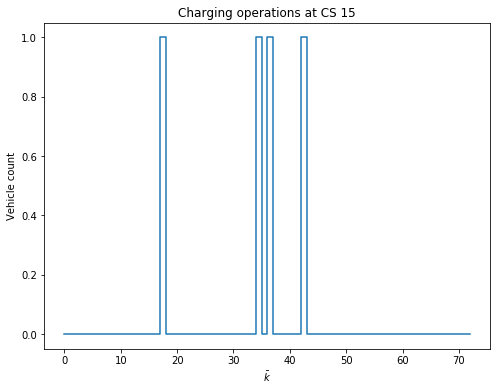

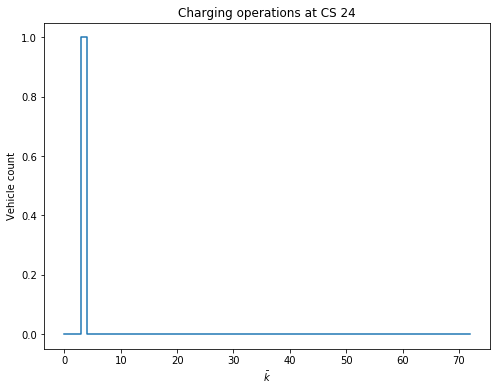

In [14]:
# %% Vehicles dynamics

# Vectors to plot

colorArrowTravel = 'SteelBlue'
colorArrowCharging = 'Crimson'
colorArrowServing = 'SeaGreen'

# Plot
maxTw = -1
minTw = 100000000000
for vehicleID, vehicle in vehiclesDict.items():
    # figures
    figX1 = figure(plot_width=600, plot_height=450,
                   title='Time the (vehicle '+str(vehicleID)+')',
                   toolbar_location=None)
    figX2 = figure(plot_width=600, plot_height=450,
                   title='SOC (vehicle '+str(vehicleID)+')',
                  y_range=(0, 100),
                  toolbar_location=None)
    figX3 = figure(plot_width=600, plot_height=450,
                   title='Payload (vehicle '+str(vehicleID)+')',
                  toolbar_location=None)
    
    # reaching leaving states for the vehicle
    reachingLeavingStates = leavingReachingSequences[vehicleID]

    # time windows
    nSeq = vehicle.nodeSequence
    kCustomers = []
    tWindowsUpper = []
    tWindowsLower = []
    for i, node in enumerate(nSeq):
        if networkDict[node].isCustomer():
            kCustomers.append(i)
            tWindowsCenter = (networkDict[node].timeWindowUp + networkDict[node].timeWindowDown) / 2.0
            tWindowsWidth =(networkDict[node].timeWindowUp - networkDict[node].timeWindowDown) / 2.0
            tWindowsUpper.append(tWindowsCenter + tWindowsWidth)
            tWindowsLower.append(tWindowsCenter - tWindowsWidth)
            # Time windows whiskers
            whiskerTW = Whisker(base=i, upper=tWindowsCenter + tWindowsWidth, lower=tWindowsCenter - tWindowsWidth)
            figX1.add_layout(whiskerTW)
            
            # update TW bounds
            if tWindowsCenter + tWindowsWidth > maxTw:
                maxTw = tWindowsCenter + tWindowsWidth
            if tWindowsCenter - tWindowsWidth < minTw:
                minTw = tWindowsCenter - tWindowsWidth
    
    # adjust fig 1 to fit TWs
    figX1.y_range=Range1d(minTw-10, maxTw+10)

    kVehicle = range(0, vehicle.si)

    figX1.line(kVehicle, reachingLeavingStates[0, :], alpha=0)
    figX1.line(kVehicle, reachingLeavingStates[1, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[2, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[3, :], alpha=0)
    figX3.line(kVehicle, reachingLeavingStates[4, :], alpha=0)

    reachingLeavingVectorPrev = reachingLeavingStates[:, 0]
    nodePrev = nSeq[0]
    kPrev = 0

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[0], y_offset=-5, text=str(node), text_baseline='top')
    figX1.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[2], y_offset=-5, text=str(node), text_baseline='top')
    figX2.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[4], y_offset=-5, text=str(node), text_baseline='top')
    figX3.add_layout(label)
    
    # Axes
    figX1.xaxis.axis_label = 'k'
    figX1.yaxis.axis_label = 'Time of the day (min)'
    figX1.axis.axis_label_text_font_size = '15pt'
    figX1.axis.major_label_text_font_size = '13pt'
    figX1.title.text_font_size = '15pt'
    
    figX2.xaxis.axis_label = 'k'
    figX2.yaxis.axis_label = 'SOC (%)'
    figX2.axis.axis_label_text_font_size = '15pt'
    figX2.axis.major_label_text_font_size = '13pt'
    figX2.title.text_font_size = '15pt'
    
    figX3.xaxis.axis_label = 'k'
    figX3.yaxis.axis_label = 'Payload (ton)'
    figX3.axis.axis_label_text_font_size = '15pt'
    figX3.axis.major_label_text_font_size = '13pt'
    figX3.title.text_font_size = '15pt'
    
    # horizontal line SOC
    hline1 = Span(location=40, dimension='width', line_color='black')
    hline2 = Span(location=80, dimension='width', line_color='black')
    figX2.renderers.extend([hline1, hline2])
    
    
    for reachingLeavingVector, node, k in zip(reachingLeavingStates[:, 1:].T, nSeq[1:], range(1, vehicle.si)):
        # x1
        label = Label(x=k, y=reachingLeavingVector[0], y_offset=-5, text=str(node), text_baseline='top')
        figX1.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[1],
                            x_end=k, y_end=reachingLeavingVector[0],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
        else:
            colorArrowSpent = colorArrowServing

        arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[0],
                           x_end=k, y_end=reachingLeavingVector[1],
                           end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                           line_color=colorArrowSpent, line_alpha=1)

        figX1.add_layout(arrowTravel)
        figX1.add_layout(arrowSpent)

        # x2
        label = Label(x=k, y=reachingLeavingVector[3], y_offset=10, text=str(node), text_baseline='top')
        figX2.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[3],
                            x_end=k, y_end=reachingLeavingVector[2],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1, line_width=1.5, visible=True)
        figX2.add_layout(arrowTravel)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
            arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[2],
                               x_end=k, y_end=reachingLeavingVector[3],
                               end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                               line_color=colorArrowSpent, line_alpha=1, line_width=1.5, visible=True)
            figX2.add_layout(arrowSpent)


        # x3
        label = Label(x=k, y=reachingLeavingVector[4], y_offset=-5, text=str(node), text_baseline='top')
        figX3.add_layout(label)

        if networkDict[nodePrev].isChargeStation():
            colorArrow = colorArrowCharging

        else:
            colorArrow = colorArrowTravel

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[4],
                            x_end=k, y_end=reachingLeavingVector[4],
                            end=VeeHead(size=8, fill_color=colorArrow, line_color=colorArrow),
                            line_color=colorArrow, line_alpha=1, line_width=1.5, visible=True)
        figX3.add_layout(arrowTravel)

        # common
        reachingLeavingVectorPrev = reachingLeavingVector
        nodePrev = node
        kPrev = k
        
    # Save
    export_png(figX1, filename=figureFolderPath+"x1_vehicle"+str(vehicleID)+".png")
    
    export_png(figX2, filename=figureFolderPath+"x2_vehicle"+str(vehicleID)+".png")
    
    export_png(figX3, filename=figureFolderPath+"x3_vehicle"+str(vehicleID)+".png")   
    
    
    # Show
    show(figX1)
    show(figX2)
    show(figX3)

# %% Plot results for CSs
for cs in networkDict['CS_LIST']:
    fig = plt.figure(figsize=(8, 6))
    csID = cs.id
    counter = thetaMatrix[csID, :]
    plt.step(np.arange(len(counter)), counter)
    plt.title('Charging operations at CS ' + str(csID))
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('Vehicle count')
    plt.savefig(figureFolderPath+"CS_"+str(cs.id)+".png")
    plt.show()


In [15]:
# %% Time of execution
tEnd = time.time()
print("Total execution time:", (tEnd - t0) * 1000.0, "ms")

Total execution time: 93177.48093605042 ms
